In [1]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [2]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
import glob
import scipy.stats as stats
import itertools
import statsmodels.api as sm
from pprint import pprint
from scripts.constants import COLUMNS_FOR_DATASET
from src.utils.data_utils import transform_for_modeling, transform_for_ci_coverage
from scripts.constants import TEST_DATASETS_FOR_DATASET, TARGET_COLUMNS_FOR_DATASET
from src.napsu_mq.napsu_mq import NapsuMQModel, NapsuMQResult
from scripts.base_ci_coverage import calculate_ci_coverage_objects

In [3]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
RESULTS_FOLDER = os.path.join(CURRENT_FOLDER, "results")
PLOTS_FOLDER = os.path.join(CURRENT_FOLDER, "plots")

In [4]:
dataset_name = "binary3d"

train_df_path = os.path.join(CURRENT_FOLDER, f"data/datasets/{dataset_name}.csv")
train_df = pd.read_csv(train_df_path)

train_df_transformed = transform_for_modeling(dataset_name, train_df)

test_df_transformed = transform_for_ci_coverage(dataset_name, train_df)
test_df_np = test_df_transformed.to_numpy()

In [5]:
train_df_transformed.dtypes

A    category
B    category
C    category
dtype: object

In [25]:
rng = jax.random.PRNGKey(42)
model = NapsuMQModel()

epsilon = 0.1
n, d = train_df_transformed.shape

result = model.fit(
    data=train_df_transformed,
    dataset_name="binary3d",
    rng=rng,
    epsilon=epsilon,
    delta=n**(-2),
    column_feature_set=[('A', 'C'), ('B', 'C')],
    use_laplace_approximation=False,
    laplace_approximation_algorithm="torch_LBFGS",
    disable_MST=True
)

Domain size: 8
Recording:  Query selection
Recording:  Calculating full marginal query
MST query set: [('A', 'C'), ('B', 'C')]
Full set of marginal queries: 8
Recording:  Calculating canonical query set
Calculating canonical queries, clique_set length: 6


  0%|                                                                                                                 | 0/6 [00:00<?, ?it/s]
2it [00:00, 2058.55it/s]

4it [00:00, 2903.13it/s]

2it [00:00, 9799.78it/s]

4it [00:00, 10292.77it/s]

2it [00:00, 4488.29it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]


Calculating new queries, not_original_clique_queries length: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 7566.39it/s]

Canonical queries: 5
Junction tree width: 1
(5,)
Number of marginal queries: 2
108.41259167380818
DP noise mean: -21.08373025820722
[30595.47034043 19442.41623073 36452.44002399 25054.46826952
 13497.78648403]
SUFF STAT MEANS
25029.6
25008.516269741795
SUFF STAT VARIANCES
65847212.24000001
65131585.622239806
Recording:  MCMC



/home/jarlehti/projects/gradu/src/napsu_mq/maximum_entropy_inference.py:134: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]     -0.01      0.01     -0.01     -0.03      0.01   4402.56      1.00
lambdas[1]      0.02      0.02      0.02     -0.01      0.05   3793.73      1.00
lambdas[2]      0.39      0.02      0.39      0.36      0.42   3089.46      1.00
lambdas[3]      0.02      0.02      0.02     -0.02      0.05   3074.63      1.00
lambdas[4]     -0.62      0.02     -0.62     -0.64     -0.59   4179.86      1.00

Number of divergences: 0
[lambdas]	 max r_hat: 0.8549
Potential energy	min: [46.35155941  0.          0.          0.        ]	max: [59.91148344  0.          0.          0.        ]	mean: [48.77373448  0.          0.          0.        ]	std: [1.58709733 0.         0.         0.        ]
Acceptance probability	min: [0.37017313 0.         0.         0.        ]	max: [1. 0. 0. 0.]	mean: [0.91366168 0.         0.         0.        ]	std: [0.10000808 0.         0.         0.        ]
Mean acceptance probability	

In [7]:
orig_posterior = result.posterior_values

In [7]:
#napsu_result_file = open(f"/tmp/napsu_mq_result.dill", "wb")
#result.store(napsu_result_file)
napsu_result_read_file = open(f"/tmp/napsu_mq_result.dill", "rb")
loaded_result: NapsuMQResult = NapsuMQResult.load(napsu_result_read_file)

InvalidFileFormatException: The given file cannot be interpreted as <class 'src.napsu_mq.napsu_mq.NapsuMQResult'>.Details:
Stored data does not have correct type identifier.

In [9]:
loaded_posterior = loaded_result.posterior_values

In [10]:
np.all(orig_posterior == loaded_posterior)

DeviceArray(True, dtype=bool)

In [7]:
X_array_orig = test_df_np[:,:-1]
y_array_orig = test_df_np[:,-1]
lr_model_orig = sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())
original_params = lr_model_orig.params
print(original_params)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63809.
Date:                Tue, 16 May 2023   Deviance:                   1.2762e+05
Time:                        18:38:02   Pearson chi2:                 1.00e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05529
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0014      0.011     87.647      0.0

In [26]:
n, d = train_df.shape
print(n)
print(d)
print(train_df.columns)

100000
3
Index(['A', 'B', 'C'], dtype='object')


In [27]:
target_column = TARGET_COLUMNS_FOR_DATASET["binary3d"]
target_column = test_df_transformed.columns.get_loc(target_column)
print(target_column)

2


In [28]:
meta = {
    'epsilon': epsilon
}

ci_intervals = np.round(np.linspace(0.05, 0.95, 5), 2)

ci_df = calculate_ci_coverage_objects(result, test_df_np, meta, confidence_intervals=ci_intervals, n_repeats=10, n_datasets=100, n_syn_datapoints=n, target_column_index=target_column)

Running CI coverage for dataset binary3d, index 0 and interval 0.05
Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 1.0026041170398454 - 1.0045600404731807
True param value: 1.0013928615336594, non-negative confidence interval: 1.0026041170398454 - 1.0045600404731807
True param value: -0.010201010300431034, confidence interval: -0.019411221867918656 - -0.017761024787097252
True param value: -0.010201010300431034, non-negative confidence interval: -0.019411221867918656 - -0.017761024787097252
Running CI coverage for dataset binary3d, index 0 and interval 0.27
Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 0.9995922131192317 - 1.0094842204346217
True param value: 1.0013928615336594, non-negative confidence interval: 0.9995922131192317 - 1.0094842204346217
True param value: -0.010201010300431034, confidence interval: -0.02420156581699592 - -0.015026097452644941
Tr

Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 0.9997414883481898 - 1.001600556160641
True param value: 1.0013928615336594, non-negative confidence interval: 0.9997414883481898 - 1.001600556160641
True param value: -0.010201010300431034, confidence interval: -0.019718269055504455 - -0.017565878478057146
True param value: -0.010201010300431034, non-negative confidence interval: -0.019718269055504455 - -0.017565878478057146
Running CI coverage for dataset binary3d, index 3 and interval 0.27
Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 1.000349469968083 - 1.0127931171777602
True param value: 1.0013928615336594, non-negative confidence interval: 1.000349469968083 - 1.0127931171777602
True param value: -0.010201010300431034, confidence interval: -0.026510459367250563 - -0.017663258451684732
True param value: -0.010201010300431034, non-negative confidence interval

Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 1.0056720692765653 - 1.0079441385351677
True param value: 1.0013928615336594, non-negative confidence interval: 1.0056720692765653 - 1.0079441385351677
True param value: -0.010201010300431034, confidence interval: -0.02278197122070283 - -0.020956294796633947
True param value: -0.010201010300431034, non-negative confidence interval: -0.02278197122070283 - -0.020956294796633947
Running CI coverage for dataset binary3d, index 6 and interval 0.27
Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 1.0006302389369734 - 1.0130364781410774
True param value: 1.0013928615336594, non-negative confidence interval: 1.0006302389369734 - 1.0130364781410774
True param value: -0.010201010300431034, confidence interval: -0.02387783331299283 - -0.014355007298740247
True param value: -0.010201010300431034, non-negative confidence interva

Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 1.0045740728895292 - 1.0063897300533886
True param value: 1.0013928615336594, non-negative confidence interval: 1.0045740728895292 - 1.0063897300533886
True param value: -0.010201010300431034, confidence interval: -0.021279789730681474 - -0.019785384021170263
True param value: -0.010201010300431034, non-negative confidence interval: -0.021279789730681474 - -0.019785384021170263
Running CI coverage for dataset binary3d, index 9 and interval 0.27
Generating data with 100000 points and 100 datasets
True param value: 1.0013928615336594, confidence interval: 0.9998190810391324 - 1.0089740741169855
True param value: 1.0013928615336594, non-negative confidence interval: 0.9998190810391324 - 1.0089740741169855
True param value: -0.010201010300431034, confidence interval: -0.021062435309819078 - -0.012697575954757371
True param value: -0.010201010300431034, non-negative confidence inte

In [29]:
ci_df[ci_df['conf_int_range'] == 0.27]

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter,nn_conf_int_start,nn_conf_int_end,nn_conf_int_width,contains_true_parameter_nn,parameter_index,epsilon
2,binary3d,0,100,0.27,0.999592,1.009484,0.009892,1.001393,True,0.999592,1.009484,0.009892,True,1,0.1
3,binary3d,0,100,0.27,-0.024202,-0.015026,0.009175,-0.010201,False,-0.024202,-0.015026,0.009175,False,2,0.1
12,binary3d,1,100,0.27,0.997660,1.008404,0.010744,1.001393,True,0.997660,1.008404,0.010744,True,1,0.1
13,binary3d,1,100,0.27,-0.021195,-0.011262,0.009933,-0.010201,False,-0.021195,-0.011262,0.009933,False,2,0.1
22,binary3d,2,100,0.27,1.000972,1.011760,0.010788,1.001393,True,1.000972,1.011760,0.010788,True,1,0.1
23,binary3d,2,100,0.27,-0.023278,-0.013672,0.009607,-0.010201,False,-0.023278,-0.013672,0.009607,False,2,0.1
32,binary3d,3,100,0.27,1.000349,1.012793,0.012444,1.001393,True,1.000349,1.012793,0.012444,True,1,0.1
33,binary3d,3,100,0.27,-0.026510,-0.017663,0.008847,-0.010201,False,-0.026510,-0.017663,0.008847,False,2,0.1
42,binary3d,4,100,0.27,0.995592,1.007373,0.011781,1.001393,True,0.995592,1.007373,0.011781,True,1,0.1
43,binary3d,4,100,0.27,-0.021553,-0.011558,0.009995,-0.010201,False,-0.021553,-0.011558,0.009995,False,2,0.1


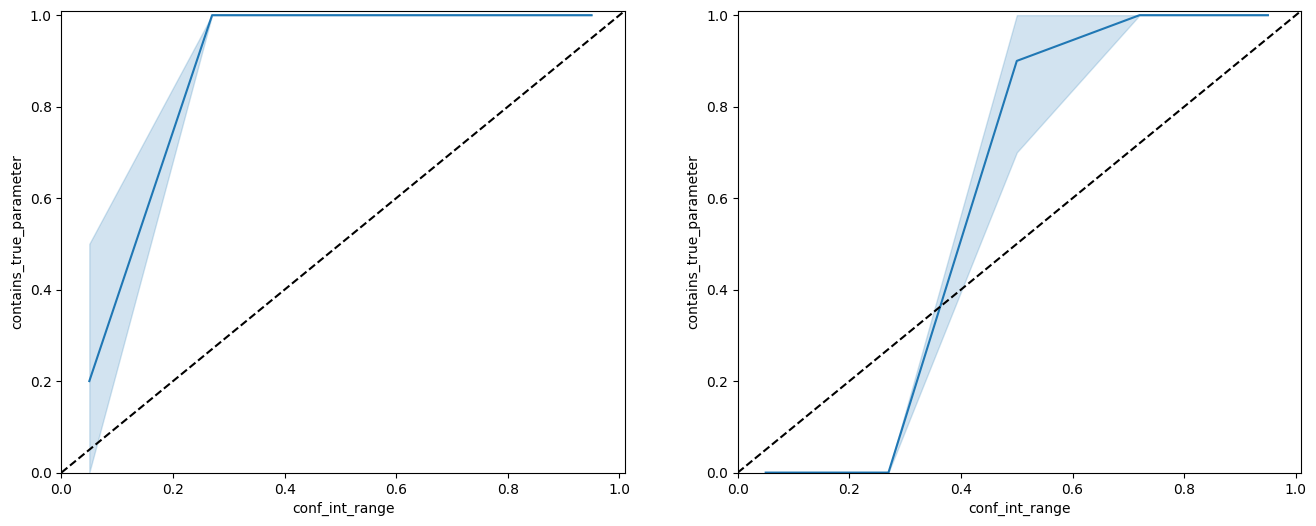

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, param in enumerate(original_params):
    ax = axes[i]
    ci_data = ci_df[ci_df['true_parameter_value'] == param]
    sns.lineplot(x="conf_int_range", y="contains_true_parameter", data=ci_data, ax=ax)
    diag = (0.0, 1.01)
    ax.plot(diag, diag, linestyle="dashed", color="black")
    ax.set_xlim(diag)
    ax.set_ylim(diag)

(0.0, 1.01)

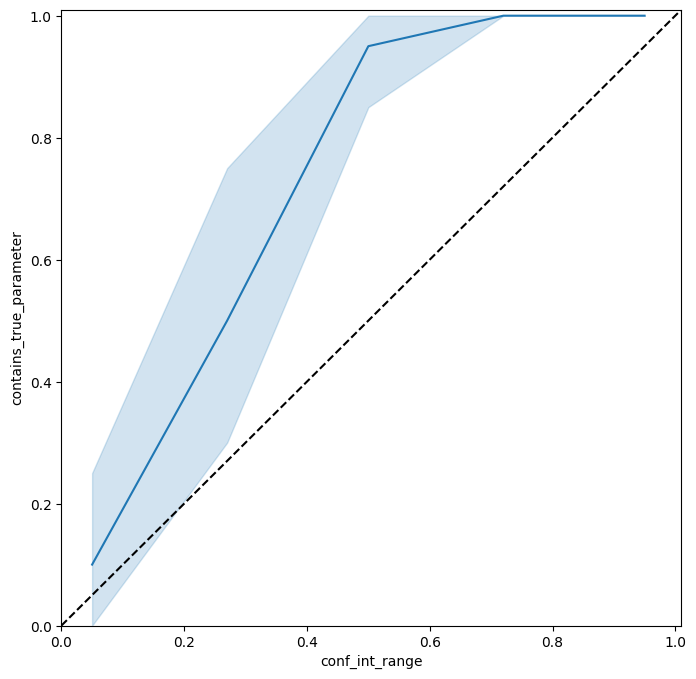

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(x="conf_int_range", y="contains_true_parameter", data=ci_df, ax=ax)
diag = (0.0, 1.01)
ax.plot(diag, diag, linestyle="dashed", color="black")
ax.set_xlim(diag)
ax.set_ylim(diag)